In [1]:
import torch
import re
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [2]:
dev = torch.device('cpu')
if torch.has_cuda:
  dev = torch.device('cuda')
print(torch.has_cuda, dev)

True cuda


In [3]:
# !wget http://www.curieux.us/simple.txt
train = open('simple.txt').read()
train = re.sub(r'\s+', ' ', train)

In [4]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(list(train))

LabelBinarizer()

In [5]:
S = len(label_binarizer.classes_)
print(f'We have {S} classes in {len(train)} input data')

We have 22 classes in 1103 input data


In [6]:
class MyRNN0(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MyRNN0, self).__init__()
    self.layer1 = torch.nn.RNNCell(input_size, hidden_size)
    self.layer2 = torch.nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    hidden2 = self.layer1(input, hidden)
    output = self.layer2(hidden2)
    return output, hidden

In [7]:
batch_size = 25 # number of instances to "unroll" before resetting history
num_hidden = 50 #

my_nn = MyRNN0(S, num_hidden, S)
my_nn.to(dev)
optimizer = torch.optim.SGD(params=my_nn.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
batches = []
for i in range(len(train) - batch_size - 1):
  X_pre = label_binarizer.transform(list(train[i: i+batch_size]))
  Y_pre = label_binarizer.transform(list(train[i+1: i+batch_size+1]))

  X = torch.tensor(X_pre, device=dev, dtype=torch.float32).view(batch_size, 1, S)
  Y = torch.tensor(Y_pre, device=dev, dtype=torch.float32).view(batch_size, 1, S)

  batches.append((X, Y))

In [9]:
h0 = torch.zeros(1, num_hidden, device=dev)
hidden = h0
losses = []

for X, Y in batches:
  score = 0
  for x, y in zip(X, Y):
    optimizer.zero_grad() # clear previous gradients
    output, hidden = my_nn(x, hidden)
    target = torch.argmax(y, 1)
    loss = loss_fn(output, target)
    score += loss.item()
    loss.backward(retain_graph=True)
    optimizer.step()
  losses.append(score)

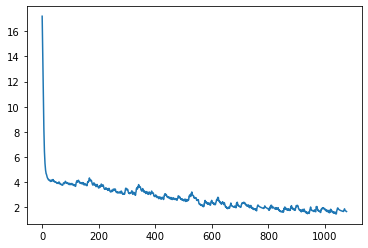

In [10]:
fig, ax = plt.subplots(1)
ax.plot(range(len(batches)), losses)
plt.show()

In [11]:
s = 'yo'
with torch.no_grad():
  my_nn.eval()
  for i in range(batch_size):
    x = torch.tensor(label_binarizer.transform([s[-1]]), device=dev, dtype=torch.float32).view(1, S)
    output, hidden2 = my_nn(x, hidden)
    output = output.to('cpu')
    y = label_binarizer.inverse_transform(output)[0]
    print(f'{s}|{y}|')
    s += y

yo|g|
yog|s|
yogs| |
yogs |c|
yogs c|a|
yogs ca|t|
yogs cat|s|
yogs cats| |
yogs cats |c|
yogs cats c|a|
yogs cats ca|t|
yogs cats cat|s|
yogs cats cats| |
yogs cats cats |c|
yogs cats cats c|a|
yogs cats cats ca|t|
yogs cats cats cat|s|
yogs cats cats cats| |
yogs cats cats cats |c|
yogs cats cats cats c|a|
yogs cats cats cats ca|t|
yogs cats cats cats cat|s|
yogs cats cats cats cats| |
yogs cats cats cats cats |c|
yogs cats cats cats cats c|a|
